# Skin Lesion Classification using HAM10000 Dataset and MobileNetv2

This project focuses on the classification of skin lesions using the HAM10000 dataset and the lightweight MobileNetV2 architecture.

**The motivation behind this work is rooted in a pressing need:**

To develop a lightweight, accessible skin lesion screening tool for use in remote and resource-limited areas where healthcare infrastructure is minimal or absent.

Skin cancer is a growing global concern, and early detection is vital for effective treatment. However, timely access to dermatologists is often limited—especially in rural and underserved communities.

**In this notebook, we:**

Tackle severe class imbalance using data augmentation

Train and fine-tune a MobileNetV2 model for image classification

Evaluate model performance using accuracy, recall, precision, F1-score, and confusion matrix

Save the final model and integrate it into a simple Streamlit web app that allows image upload and prediction—intended as a screening aid, not a diagnostic tool

**Note:** This prototype is for educational and exploratory purposes. It is not suitable for clinical use without extensive validation, regulatory review, and expert annotation.

# Data Loading

In [2]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import numpy as np

In [2]:
# Load the Ground Truth CSV
df = pd.read_csv("ISIC2018_Task3_Training_GroundTruth.csv")

In [3]:
# Rename 'image' column for consistency
df = df.rename(columns={"image": "image_id"})

In [4]:
# Add full image path
df["image_path"] = "training_images/" + df["image_id"] + ".jpg"

In [5]:
# Map ISIC class codes to full names
label_map = {
    "AKIEC": "Actinic Keratoses",
    "BCC": "Basal Cell Carcinoma",
    "BKL": "Benign Keratosis",
    "DF": "Dermatofibroma",
    "MEL": "Melanoma",
    "NV": "Melanocytic Nevi",
    "VASC": "Vascular Lesions"
}

In [6]:
# Extract the class code from one-hot
df["label_code"] = df[['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']].idxmax(axis=1)

In [7]:
# Map to full label name
df["label_name"] = df["label_code"].map(label_map)

In [8]:
# Convert label name to integer (0–6)
df["label_int"] = df["label_name"].astype("category").cat.codes

In [9]:
# Preview class counts
print("Class distribution:")
print(df["label_name"].value_counts())

Class distribution:
Melanocytic Nevi        6705
Melanoma                1113
Benign Keratosis        1099
Basal Cell Carcinoma     514
Actinic Keratoses        327
Vascular Lesions         142
Dermatofibroma           115
Name: label_name, dtype: int64


In [10]:
# Save class names in order for later use (like in GradCAM or confusion matrix)
class_names = df[['label_name', 'label_int']].drop_duplicates().sort_values("label_int")["label_name"].tolist()
print("\nClass label order:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")


Class label order:
0: Actinic Keratoses
1: Basal Cell Carcinoma
2: Benign Keratosis
3: Dermatofibroma
4: Melanocytic Nevi
5: Melanoma
6: Vascular Lesions


In [11]:
# Use the entire dataset for training and evaluation
dataset_df = df.reset_index(drop=True)

In [12]:
# Stratified train/validation split (80/20)
train_df, val_df = train_test_split(
    dataset_df,
    test_size=0.2,
    stratify=dataset_df["label_int"],
    random_state=42
)

print(f"\nTrain samples: {len(train_df)}")
print(f"Val samples: {len(val_df)}")


Train samples: 8012
Val samples: 2003


In [13]:
# Class counts
class_counts = train_df['label_int'].value_counts()
max_count = class_counts.max()

# Group images by class
grouped = train_df.groupby('label_int')

for label, group in grouped:
    print(f"Label {label}: {len(group)} samples")

Label 0: 262 samples
Label 1: 411 samples
Label 2: 879 samples
Label 3: 92 samples
Label 4: 5364 samples
Label 5: 890 samples
Label 6: 114 samples


In [14]:
# Check for any missing image files
missing = [p for p in dataset_df["image_path"] if not os.path.exists(p)]
print(f"\nMissing images: {len(missing)}")


Missing images: 0


# Data Preprocessing and Augmentation

This section prepares the HAM10000 dataset for training the MobileNetV2 classifier. The key steps are:

**Image Preprocessing:** Images are resized to 224×224 to match MobileNetV2’s input requirements. Pixel values are normalized to the [0,1] range.

**Data Augmentation (training only):** Random flips, brightness/contrast adjustments, saturation, hue shifts, rotations (0°, 90°, 180°, 270°), and zoom are applied to make the model  robust to visual variations.

**Conversion to TensorFlow Datasets:** Pandas DataFrames are converted into tf.data.Dataset objects for efficient, scalable loading.

**Class Balancing:** A custom function ensures that each class contributes an equal number of samples by repeating underrepresented classes. This is important due to class imbalance in the HAM10000 dataset.

**Previewing the Dataset:** A batch of training images is visualized to verify augmentation, class balance, and preprocessing correctness before training.

In [15]:
# Import libraries
import tensorflow as tf
import tensorflow_addons as tfa

In [16]:
# Set constants
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
num_classes = train_df["label_int"].nunique()

In [17]:
# Function to load and preprocess each image
def load_image(image_path, label):
    # Load image file
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    
    # Resize to MobileNet input size
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    
    # Normalize to [0, 1]
    img = img / 255.0
    return img, label

In [18]:
# Function for image augmentation (only during training)
def augment_image(image, label):
    # Flip
    image = tf.image.random_flip_left_right(image)
    
    # Brightness and contrast
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Add saturation and hue jitter
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.02)
    
    # Random rotation (0, 90, 180, 270 degrees)
    angles = tf.constant([0., 1., 2., 3.], dtype=tf.float32) * (np.pi / 2)
    angle = tf.random.shuffle(angles)[0]
    image = tfa.image.rotate(image, angles=angle)

    # Random zoom
    scales = list(np.arange(0.8, 1.0, 0.05))
    scale = tf.random.shuffle(scales)[0]
    new_size = tf.cast(scale * tf.cast(tf.shape(image)[:2], tf.float32), tf.int32)
    image = tf.image.resize_with_crop_or_pad(image, new_size[0], new_size[1])
    image = tf.image.resize(image, [224, 224])
    
    return image, label

In [19]:
# Convert pandas dataframe to TensorFlow Dataset
def df_to_dataset(df, augment=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((df['image_path'].values, df['label_int'].values))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

In [20]:
# Create balanced dataset
def make_balanced_class_ds(class_df, label, augment_fn=True):
    ds = tf.data.Dataset.from_tensor_slices((class_df['image_path'].values, [label]*len(class_df)))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if augment_fn:
        ds = ds.map(augment_image, num_parallel_calls=AUTOTUNE)
    ds = ds.repeat().take(max_count)
    return ds 

balanced_datasets = []

for label in sorted(train_df['label_int'].unique()):
    class_df = train_df[train_df['label_int'] == label]
    print(f"Processing label {label} with {len(class_df)} samples")

    if len(class_df) > 0:
        ds = make_balanced_class_ds(class_df, label, augment_fn=False)
        balanced_datasets.append(ds)

Processing label 0 with 262 samples
Processing label 1 with 411 samples
Processing label 2 with 879 samples
Processing label 3 with 92 samples
Processing label 4 with 5364 samples
Processing label 5 with 890 samples
Processing label 6 with 114 samples


In [21]:
# Combine and batch the balanced data
balanced_train_ds = balanced_datasets[0]
for ds in balanced_datasets[1:]:
    balanced_train_ds = balanced_train_ds.concatenate(ds)

balanced_train_ds = balanced_train_ds.shuffle(10000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Inspect class counts
from collections import Counter

label_counter = Counter()
total = 0
for images, labels in balanced_train_ds.unbatch():
    label = labels.numpy()
    label_counter[label] += 1
    total += 1

print(f"\nTotal images: {total}")
for label in sorted(label_counter):
    print(f"Label {label}: {label_counter[label]} samples")


Total images: 37548
Label 0: 5364 samples
Label 1: 5364 samples
Label 2: 5364 samples
Label 3: 5364 samples
Label 4: 5364 samples
Label 5: 5364 samples
Label 6: 5364 samples


In [22]:
# Create datasets
train_ds = balanced_train_ds
val_ds = df_to_dataset(val_df, augment=False, shuffle=False)

In [23]:
# Preview a batch
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


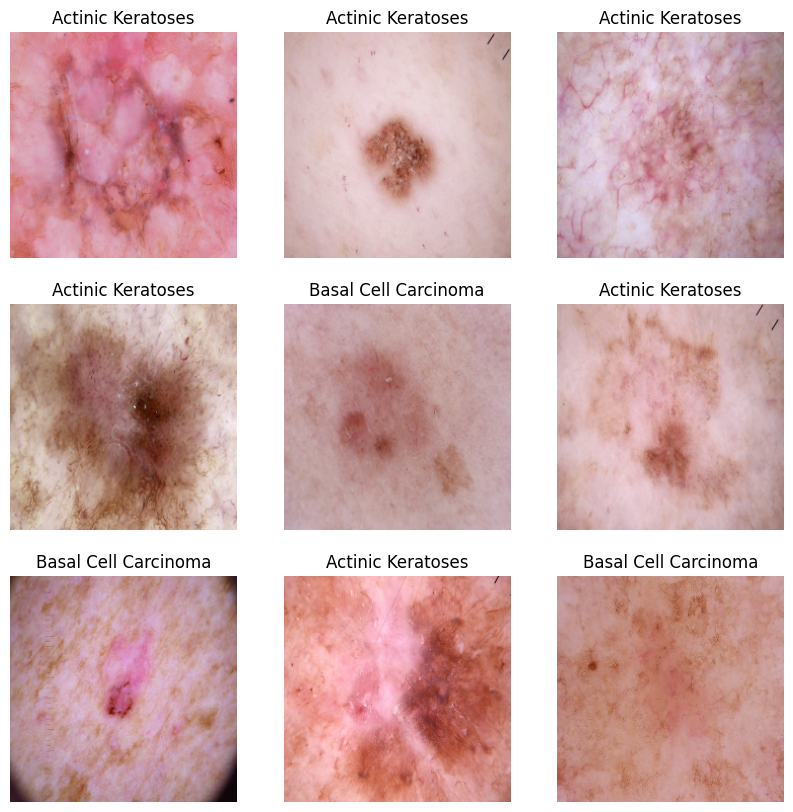

In [24]:
# Visualize some images
import matplotlib.pyplot as plt

# Number of images to display
NUM_IMAGES = 9

# Get one batch of data
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    
    for i in range(NUM_IMAGES):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(tf.clip_by_value(images[i], 0.0, 1.0))
        label_index = labels[i].numpy()
        plt.title(class_names[label_index])
        plt.axis("off")
    break 

# Model Training 

In this section, we build and fine-tune a lightweight MobileNetV2 model for the task of skin lesion classification. The base model is initialized with ImageNet weights and fine-tuned on the balanced HAM10000 dataset.

A custom classifier head is added with dropout and L2 regularization to prevent overfitting.

The model is compiled using the Adam optimizer and trained with Sparse Categorical Crossentropy loss.

Learning rate scheduling, early stopping, and model checkpointing are used to improve convergence and save the best model.

**After training:**

    We evaluate the model on the validation set using accuracy, precision, recall, and F1-score.

    A confusion matrix is plotted to visually inspect the model’s performance across the 7 classes.

Despite being lightweight and optimized for deployment in resource-constrained settings, the model achieves a solid validation accuracy of ~83%, showing its potential for real-world screening applications.

In [25]:
from tensorflow.keras import layers, models, regularizers

# Load pretrained MobileNetV2 without the top classification layer
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Unfreeze the base model 
base_model.trainable = True

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    
    # dense units
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    
    # dropout
    layers.Dropout(0.5),
    
    layers.Dense(num_classes, activation='softmax')  # 7 output classes
])

# learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [26]:
# Setup Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model_final_MobNet.keras",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_weights_only=False
)

earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_accuracy',
    verbose=1
)

In [27]:
# Train the model
EPOCHS = 60

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, lr_scheduler]
)

Epoch 1/60
1174/1174 [==============================] - ETA: 0s - loss: 0.6274 - accuracy: 0.8203
Epoch 1: val_accuracy improved from -inf to 0.01398, saving model to best_model_final_MobNet.keras
1174/1174 [==============================] - 154s 118ms/step - loss: 0.6274 - accuracy: 0.8203 - val_loss: 34.0805 - val_accuracy: 0.0140 - lr: 0.0010
Epoch 2/60
1173/1174 [============================>.] - ETA: 0s - loss: 0.4444 - accuracy: 0.8713
Epoch 2: val_accuracy did not improve from 0.01398
1174/1174 [==============================] - 142s 117ms/step - loss: 0.4443 - accuracy: 0.8713 - val_loss: 65.1254 - val_accuracy: 0.0140 - lr: 0.0010
Epoch 3/60
1173/1174 [============================>.] - ETA: 0s - loss: 0.3755 - accuracy: 0.8937
Epoch 3: val_accuracy improved from 0.01398 to 0.02247, saving model to best_model_final_MobNet.keras
1174/1174 [==============================] - 190s 157ms/step - loss: 0.3754 - accuracy: 0.8937 - val_loss: 49.5357 - val_accuracy: 0.0225 - lr: 0.0010
E

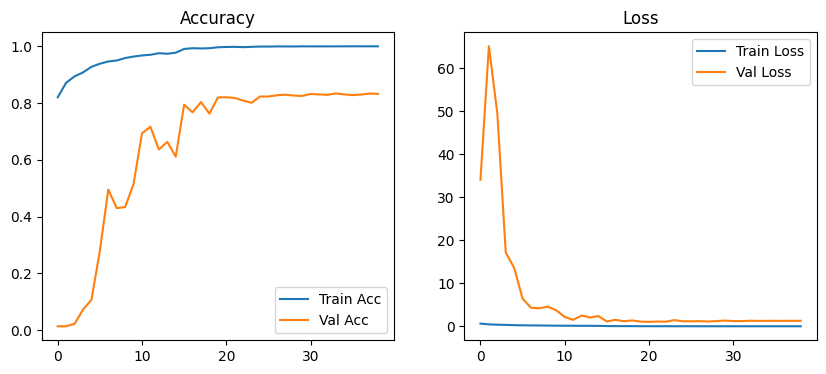

In [28]:
# Plot Accuracy and Loss Curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

In [29]:
# Evaluation Metrics
import numpy as np

# Convert all batches in val_ds to predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 1s 588ms/step


In [30]:
# Classification Report
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

                      precision    recall  f1-score   support

   Actinic Keratoses       0.88      0.45      0.59        65
Basal Cell Carcinoma       0.84      0.74      0.78       103
    Benign Keratosis       0.74      0.60      0.67       220
      Dermatofibroma       0.89      0.35      0.50        23
    Melanocytic Nevi       0.86      0.96      0.91      1341
            Melanoma       0.66      0.53      0.59       223
    Vascular Lesions       0.92      0.82      0.87        28

            accuracy                           0.83      2003
           macro avg       0.83      0.64      0.70      2003
        weighted avg       0.83      0.83      0.82      2003



<Figure size 800x600 with 0 Axes>

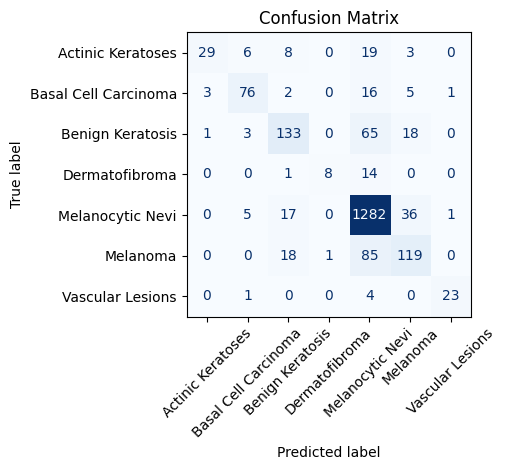

In [31]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Model Testing

After training the model and validating its performance, the next step involves evaluating its generalization capabilities on a completely unseen test set. This section includes:

**Preprocessing:** Mapping raw test labels to human-readable class names.

**Test Data Pipeline:** Ensuring no augmentation or shuffle is applied to maintain test integrity.

**Performance Metrics:**

**> Test Accuracy:** Basic overall accuracy score.

**> Classification Report:** Per-class precision, recall, and F1-score to evaluate strengths and weaknesses.

**> Confusion Matrix:** Visualization of misclassifications across all classes.

**> Visual Results:** Displaying actual test images along with predicted and true labels for intuitive error inspection. Green indicates correct prediction, red indicates a mismatch.

This comprehensive evaluation helps assess how well the model performs in real-world scenarios where it encounters diverse and unseen skin lesions.

In [3]:
# Preprocess Test Labels

# Load test ground truth
test_df = pd.read_csv("ISIC2018_Task3_Test_GroundTruth.csv")
test_df = test_df.rename(columns={"image": "image_id"})
test_df["image_path"] = "test_images/" + test_df["image_id"] + ".jpg"

# Map class codes to full names
label_map = {
    "AKIEC": "Actinic Keratoses",
    "BCC": "Basal Cell Carcinoma",
    "BKL": "Benign Keratosis",
    "DF": "Dermatofibroma",
    "MEL": "Melanoma",
    "NV": "Melanocytic Nevi",
    "VASC": "Vascular Lesions"
}

test_df["label_code"] = test_df[['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']].idxmax(axis=1)
test_df["label_name"] = test_df["label_code"].map(label_map)
test_df["label_int"] = test_df["label_name"].astype("category").cat.codes

In [33]:
# Create Test Dataset Pipeline

# No shuffle, no augment for test set
test_ds = df_to_dataset(test_df, augment=False, shuffle=False)

In [34]:
# Basic accuracy
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

48/48 [==============================] - 2s 37ms/step - loss: 1.8647 - accuracy: 0.7626
Test Accuracy: 0.7626


In [35]:
# Evaluation Metrics

# Get predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels.numpy())

1/1 [==============================] - 0s 20ms/step


In [36]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))

                      precision    recall  f1-score   support

   Actinic Keratoses       0.61      0.53      0.57        43
Basal Cell Carcinoma       0.75      0.51      0.60        93
    Benign Keratosis       0.69      0.57      0.63       217
      Dermatofibroma       1.00      0.32      0.48        44
    Melanocytic Nevi       0.80      0.96      0.87       909
            Melanoma       0.55      0.37      0.44       171
    Vascular Lesions       0.76      0.37      0.50        35

            accuracy                           0.76      1512
           macro avg       0.74      0.52      0.58      1512
        weighted avg       0.75      0.76      0.74      1512



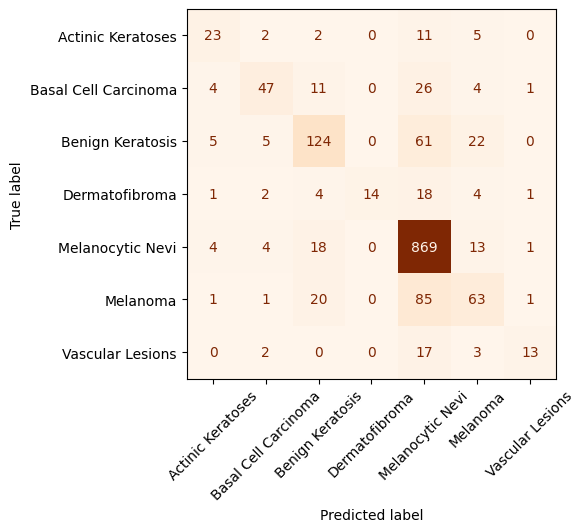

In [37]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap="Oranges", colorbar=False)

In [38]:
# Display the evaluated images

# Get predictions again if needed
y_true = []
y_pred = []
image_paths = []

for images, labels in test_ds:
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels.numpy())
    image_paths.extend(images.numpy())

1/1 [==============================] - 0s 20ms/step


In [39]:
# Convert predictions and labels to numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

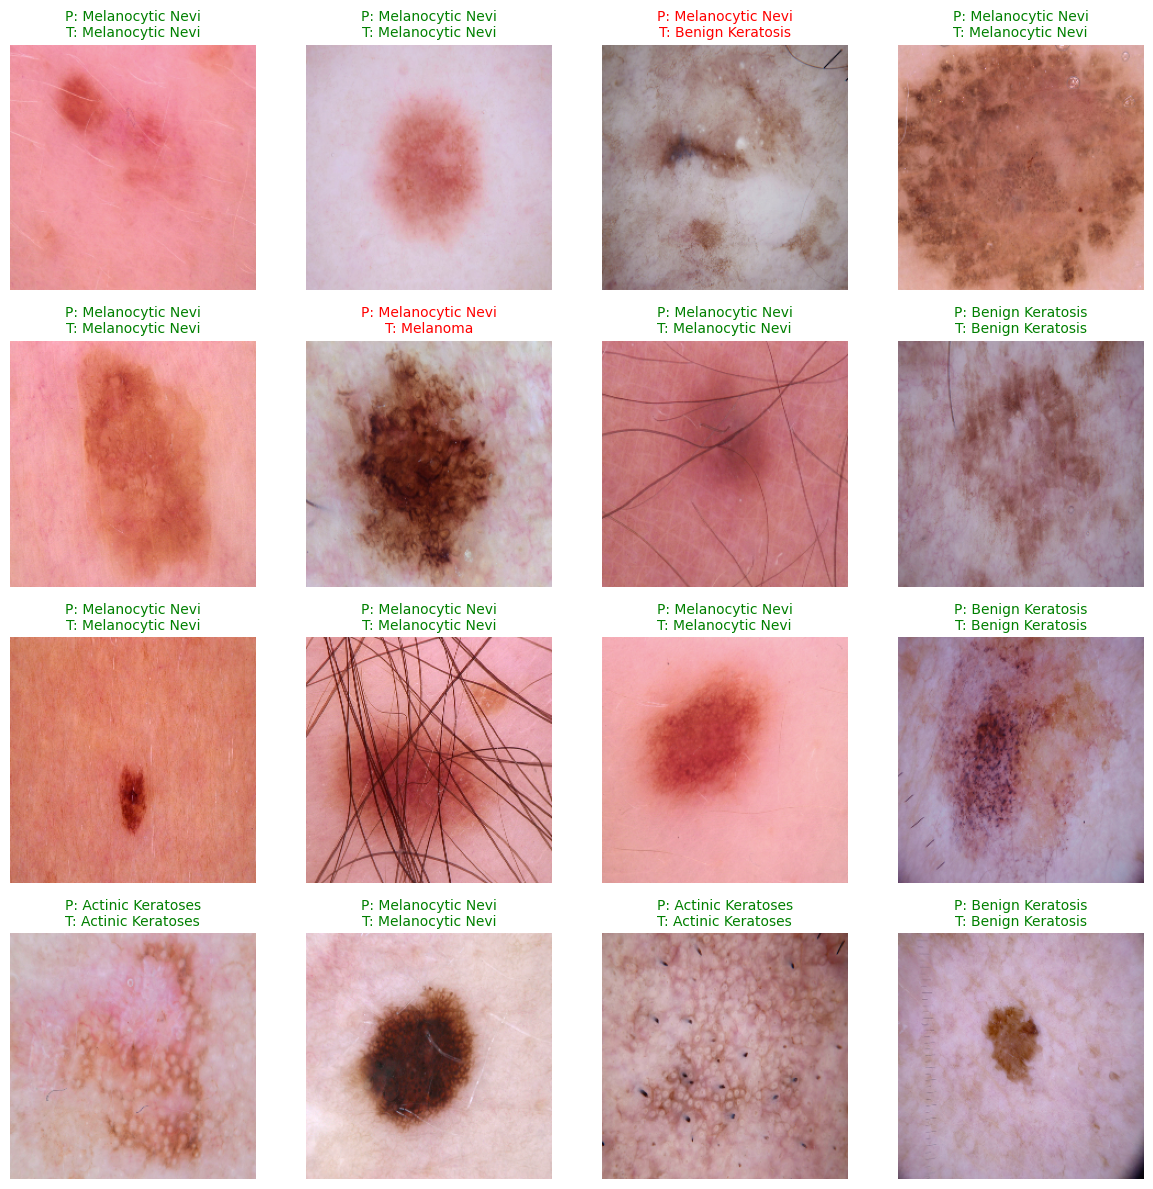

In [40]:
# Plot a few sample predictions
NUM_IMAGES = 16  # e.g., 4x4 grid
plt.figure(figsize=(12, 12))

for i in range(NUM_IMAGES):
    ax = plt.subplot(4, 4, i + 1)
    
    # Get image, label, prediction
    img_tensor = image_paths[i]
    img_array = img_tensor  # already normalized float32 array
    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred[i]]
    
    plt.imshow(img_array)
    color = "green" if y_true[i] == y_pred[i] else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Saliency Map

The saliency map offers a visual explanation of the model's prediction by highlighting which regions of the input image had the most influence on the outcome. Brighter areas indicate higher impact, helping us understand what parts of the lesion the model is "paying attention to" when making decisions.

In [41]:
# Take one image from test_ds
for images, labels in test_ds.take(1):
    image = images[0]  # shape: (224, 224, 3)
    label = labels[0]  # ground truth label
    break

# Expand dims to create batch
input_tensor = tf.expand_dims(image, axis=0)

In [42]:
# Get the prediction index (i.e., predicted class)

# Get model prediction
preds = model(input_tensor)
pred_index = tf.argmax(preds[0])

In [43]:
# Compute gradients of predicted class w.r.t. input image

with tf.GradientTape() as tape:
    tape.watch(input_tensor)  # track input
    predictions = model(input_tensor)
    top_class = predictions[:, pred_index]

# Compute gradient of output w.r.t input
grads = tape.gradient(top_class, input_tensor)  # shape: (1, 224, 224, 3)

In [44]:
# Process the gradient into a saliency map

# Take absolute value and reduce over color channels
saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]  # shape: (224, 224)

# Normalize to [0, 1]
saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency))

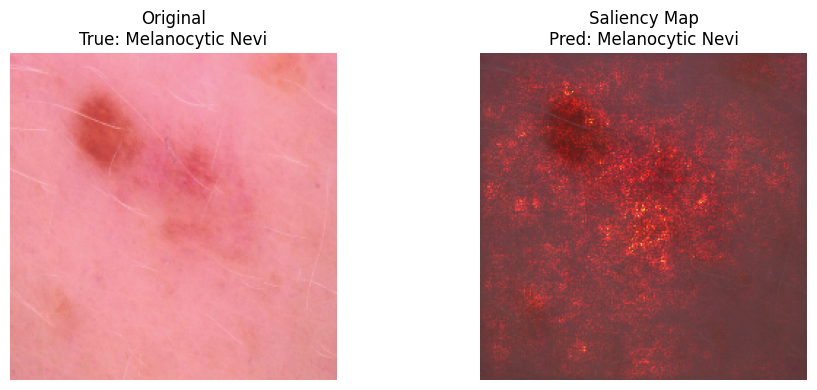

In [47]:
# Display original image and saliency map

plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image.numpy())
plt.title(f"Original\nTrue: {class_names[label]}")
plt.axis('off')

# Saliency map
plt.subplot(1, 2, 2)
plt.imshow(image.numpy())
plt.imshow(saliency, cmap='hot', alpha=0.6)
plt.title(f"Saliency Map\nPred: {class_names[pred_index]}")
plt.axis('off')

plt.tight_layout()
plt.show()

# Future Scope & Lightweight Considerations

**Overfitting:** The model shows clear signs of overfitting — training accuracy reaches 100% while validation accuracy saturates earlier. This is expected when fine-tuning powerful pretrained models like MobileNetV2 on small, imbalanced datasets.

**Class Imbalance:** While basic data augmentation helped, other balancing techniques like class weights and focal loss didn’t lead to noticeable gains. Semantic imbalance (e.g., Melanocytic Nevi dominating) remains a challenge.

**Lightweight First:** A custom lightweight CNN was also attempted but underperformed, possibly due to limited capacity or suboptimal design. Still, optimizing or redesigning small architectures remains a promising direction aligned with the lightweight goal.

**Next Steps (Aligned with App Use-Case):** Explore GANs or light augmentation pipelines that increase variability without increasing model size.

Experiment with MobileNet variants or quantization-aware training to compress the final model.